# Lab

http://tinyurl.com/enron-db

In [10]:
%reload_ext sql

In [11]:
%%bash
sqlite3 enron.db .tables

Employee          EmployeeWithVars  MessageBase       RecipientBase   
EmployeeBase      Message           Recipient       


We only care about the `*Base` tables:

- EmployeeBase
- MessageBase
- RecipientBase

(The other tables are derived from those. We don't need them for this exercise.)

In [12]:
%%sql sqlite:///enron.db
SELECT * FROM MessageBase LIMIT 5

Done.


mid,filename,unix_time,subject,from_eid
1,taylor-m/sent/11,910930020,Cd$ CME letter,138
2,taylor-m/sent/17,911459940,Indemnification,138
3,taylor-m/sent/18,911463840,Re: Indemnification,138
4,taylor-m/sent/23,911874180,"Re: Coral Energy, L.P.",138
5,taylor-m/sent/27,912396120,Bankruptcy Code revisions,138


In [13]:
%%sql sqlite:///enron.db
SELECT * FROM EmployeeBase LIMIT 5

Done.


eid,name,department,longdepartment,title,gender,seniority
1,John Arnold,Trading,ENA Gas Financial,VP Trading,Male,Senior
2,Harry Arora,Trading,ENA East Power,VP Trading,Male,Senior
3,Robert Badeer,Trading,ENA West Power,Mgr Trading,Male,Junior
4,Susan Bailey,Legal,ENA Legal,Specialist Legal,Female,Junior
5,Eric Bass,Trading,ENA Gas Texas,Trader,Male,Junior


In [14]:
%%sql sqlite:///enron.db
SELECT * FROM RecipientBase LIMIT 5

Done.


mid,rno,to_eid
1,1,59
2,1,15
3,1,15
4,1,109
4,2,49


`from_eid` looks like a foreign key

In [15]:
%%sql sqlite:///enron.db
SELECT unix_time, name, department, title, gender, seniority, subject, filename 
FROM EmployeeBase JOIN MessageBase ON eid = from_eid LIMIT 5

Done.


unix_time,name,department,title,gender,seniority,subject,filename
910930020,Mark E. Taylor,Legal,VP & Gen Cnsl,Male,Senior,Cd$ CME letter,taylor-m/sent/11
911459940,Mark E. Taylor,Legal,VP & Gen Cnsl,Male,Senior,Indemnification,taylor-m/sent/17
911463840,Mark E. Taylor,Legal,VP & Gen Cnsl,Male,Senior,Re: Indemnification,taylor-m/sent/18
911874180,Mark E. Taylor,Legal,VP & Gen Cnsl,Male,Senior,"Re: Coral Energy, L.P.",taylor-m/sent/23
912396120,Mark E. Taylor,Legal,VP & Gen Cnsl,Male,Senior,Bankruptcy Code revisions,taylor-m/sent/27


Finally, `RecipientBase`:

In [16]:
%%sql sqlite:///enron.db
SELECT * FROM RecipientBase LIMIT 9

Done.


mid,rno,to_eid
1,1,59
2,1,15
3,1,15
4,1,109
4,2,49
4,3,120
4,4,59
5,1,45
5,2,53


It looks like we can use this to determine how many recipients each message received  
i.e. `MAX(rno)`

In [17]:
%%sql sqlite:///enron.db
SELECT * FROM RecipientBase WHERE rno = 57

Done.


mid,rno,to_eid
12116,57,51
12151,57,51


In [18]:
%%sql sqlite:///enron.db
SELECT * FROM MessageBase WHERE mid IN (12116, 12151)

Done.


mid,filename,unix_time,subject,from_eid
12116,baughman-d/all_documents/398,990510780,,67
12151,baughman-d/ect_admin/22,990546780,,67


In [19]:
%%sql sqlite:///enron.db
SELECT * FROM EmployeeBase WHERE eid=67

Done.


eid,name,department,longdepartment,title,gender,seniority
67,John J. Lavorato,Other,EWS,ENA President & CEO,Male,Senior


Who sent the email to the most recipients?

In [20]:
%%sql sqlite:///enron.db
SELECT name, title, MAX(rno)
FROM EmployeeBase 
JOIN MessageBase ON eid = from_eid 
JOIN RecipientBase USING(mid)

Done.


name,title,MAX(rno)
John J. Lavorato,ENA President & CEO,57


Who are the top five senders of mass emails?

In [21]:
%%sql sqlite:///enron.db
SELECT name, title, MAX(rno) AS recipient_count
FROM EmployeeBase 
JOIN MessageBase ON eid = from_eid 
JOIN RecipientBase USING(mid) 
GROUP BY name, title ORDER BY recipient_count DESC LIMIT 5

Done.


name,title,recipient_count
John J. Lavorato,ENA President & CEO,57
Kenneth Lay,President & CEO,52
Sally Beck,VP,49
Monique Sanchez,Associate,24
Louise Kitchen,COO,21


In [22]:
%%sql sqlite:///enron.db
SELECT name, department, title, gender, seniority, subject, filename, unix_time
FROM EmployeeBase JOIN MessageBase ON eid = from_eid 
ORDER BY unix_time DESC LIMIT 1

Done.


name,department,title,gender,seniority,subject,filename,unix_time
Stephanie Panus,Legal,Specialist Legal,Female,Junior,Master Termination Log,germany-c/inbox/23,1024666654


In [24]:
%%sql sqlite:///enron.db
SELECT name, department, title, gender, seniority, subject, filename, unix_time
FROM (SELECT * FROM MessageBase ORDER BY unix_time DESC LIMIT 1)
JOIN RecipientBase USING(mid)
JOIN EmployeeBase ON eid = to_eid

Done.


name,department,title,gender,seniority,subject,filename,unix_time
Chris Germany,Trading,Mgr Trading,Male,Junior,Master Termination Log,germany-c/inbox/23,1024666654
Sara Shackleton,Legal,Gen Cnsl Asst,Female,Junior,Master Termination Log,germany-c/inbox/23,1024666654
Susan Bailey,Legal,Specialist Legal,Female,Junior,Master Termination Log,germany-c/inbox/23,1024666654


In [25]:
%%sql sqlite:///enron.db
SELECT name, department, title, gender, seniority
FROM EmployeeBase LEFT JOIN MessageBase ON eid = from_eid 
WHERE mid IS NULL

Done.


name,department,title,gender,seniority
Mary Fischer,Other,Employee,Female,Junior
Rob G. Gay,Other,Employee,Male,Junior
Judy Hernandez,Other,Administrator,Female,Junior
Michael E. Taylor,Trading,Trader,Male,Junior


In [ ]:
%%sql sqlite:///enron.db
SELECT name, department, title, gender, seniority
FROM EmployeeBase LEFT JOIN RecipientBase ON eid = to_eid 
WHERE mid IS NULL

In [2]:
%matplotlib inline

In [3]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('enron.db')

In [8]:
MessageBase = pd.read_sql("""SELECT mid, unix_time, subject, from_eid FROM MessageBase""", conn, "mid")
recipient_counts = pd.read_sql("""SELECT mid, datetime(unix_time, 'unixepoch') AS time_sent, MAX(rno) AS recipient_count 
                        FROM MessageBase JOIN RecipientBase USING (mid) GROUP BY mid, time_sent""", conn, "mid")

In [5]:
w = recipient_counts.time_sent.map(lambda dt: pd.Period(dt, freq='W'))

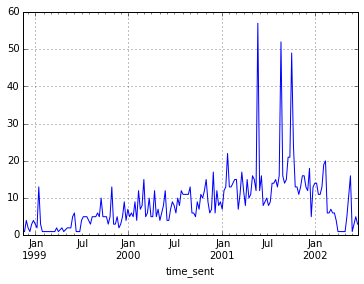

In [6]:
recipient_counts.groupby(w).recipient_count.max().plot()

In [9]:
recipient_counts.join(MessageBase).sort(ascending=False, columns=['recipient_count']).head()

,time_sent,recipient_count,unix_time,subject,from_eid
mid,,,,,
12116,2001-05-22 05:53:00,57,990510780,,67
12151,2001-05-22 15:53:00,57,990546780,,67
12140,2001-05-22 10:53:56,55,990528836,,67
14404,2001-08-23 11:24:25,52,998565865,Associate/Analyst Program,68
16035,2001-10-05 14:03:57,49,1002290637,Enron Center South (ECS) Move Back-up Plan,7
